In [1]:
# Importing packages needed for the project
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

# Pictures and videos are the same size as this one, using its shape down below
img = mpimg.imread('test_images/solidWhiteRight.jpg')

In [14]:
# Nessesary variables
α = 0.9                 # Weight factor for initial image
β = 0.4                 # Weight factor for new image
λ = 0.22                # Scalar added to each sum (of new and initial image), see weighted_img function
kernel_size = 7         # Size of the n x n matrix used as kernel in gaussian blur
low_threshold = 50      # Value for the canny function, defining the first threshold
high_threshold = 150    # Value for the canny function, defining the second threshold
rho = 1                 # Distance resolution in pixels of the Hough grid
theta = np.pi/90        # Angular resolution in radians of the Hough grid
threshold = 15          # Minimum number of votes (intersections in Hough grid cell)
min_line_length = 70    # Minimum number of pixels in a line
max_line_gap = 30       # Maximum gap in pixels between connectable line segments
min_slope_value = 0.5   # Defining the minimum slope value. Lines under this value is not lane lines.
left_line_stack = []    # For keeping a stack of left lines
right_line_stack = []   # For keeping a stack of right lines
left_line_history = []  # For keeping a history of left lines, if there is no left lines
right_line_history = [] # For keeping a history of right lines, if there is no right lines
H = img.shape[0]        # Getting the hight of the image
Hr = H*0.6              # Reducing the hight
W = img.shape[1]        # Getting the width of the image
vertices = np.array([(x * W, y * H) for (x,y) in [[0.05,1], [0.46, 0.60], [0.54, 0.60], [1, 1]]], np.int32) # ROI


In [15]:
# Making functions used in the pipeline 


def grayscale(img):
    """Applies the Grayscale transform"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)



def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform, which tracks edges by hysteresis"""
    return cv2.Canny(img, low_threshold, high_threshold)



def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)



def region_of_interest(img, vertices):
    """Applies an image mask"""
    mask = np.zeros_like(img)
    
    # Defining number of channels to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2] 
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # Filling pixels inside the polygon defines by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # Returning the image only where the masked pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image



def get_hough_line(x1,y1,x2,y2):
    """Returns the line in hough space"""
    m = (y2-y1)/(x2-x1)
    b = y1 - m * x1
    return m,b 



def get_xvalue(m, b, y):
    """Returns the x value from Hough values"""
    return int((y-b) / m)



def get_m_b_smoothed(mb, hist):
    """Gets smoothed hough values based on averaging the last ones"""

    hist_frames = 10
    hist.append(mb)
    
    m_sum = 0
    b_sum = 0
    l = len(hist[-hist_frames:])
    
    for (m, b) in hist[-hist_frames:]:
        m_sum += m
        b_sum += b
    
    return (m_sum / l, b_sum / l)



def get_lane_coords(averige_line):
    """Returns the lane coordinates based on the averige lines"""
        
    # Find coordinates for left lines
    if True in averige_line:
            # Gets the Hough values m and b
            left_m, left_b = get_m_b_smoothed(averige_line[True], left_line_history)
            # Using m and b to find x and y values
            lx1, ly1, lx2, ly2 = get_xvalue(left_m, left_b, Hr), Hr, get_xvalue(left_m, left_b, H), H
            left_line_stack.append((lx1, ly1, lx2, ly2))
    else:
            lx1, ly1, lx2, ly2 = left_line_stack[-1] # Gets the previous line

    # Find coordinates for right lines
    if False in averige_line:
            # Gets the Hough values m and b
            right_m, right_b = get_m_b_smoothed(averige_line[False], right_line_history)
            # Using m and b to find x and y values
            rx1, ry1, rx2, ry2 = get_xvalue(right_m, right_b, Hr), Hr, get_xvalue(right_m, right_b, H), H
            right_line_stack.append((rx1, ry1, rx2, ry2))

    else:
            rx1, ry1, rx2, ry2 = right_line_stack[-1] # Gets the previous line


    return  lx1, ly1, lx2, ly2, rx1, ry1, rx2, ry2            
    

    
def draw_lane_fill(img, lines):
    """Drawing blue lane fill"""
    
    # Left lane lines in True (positive slopes), and right lane lines in False (negative slopes)
    line_map = {True : [], False : []}
    
    # Finding appropriate hough lines and appending to line_map dictionary
    for line in lines:
        for x1,y1,x2,y2 in line:
            m, b = get_hough_line(x1,y1,x2,y2)
            if (abs(m) < min_slope_value) : continue
            line_map[m > 0].append((m,b))
            
    # Making average lines of all the candidates
    averige_line = {}
    for key in line_map:
        if len(line_map[key]) == 0 : continue
        m_sum = 0
        b_sum = 0
        for m, b in line_map[key]:
            m_sum += m
            b_sum += b
            
        m_avg = m_sum / len(line_map[key])
        b_avg = b_sum / len(line_map[key])
        averige_line[key] = m_avg, b_avg

    # Getting the left(l) and right(r) lane coordinates
    lx1, ly1, lx2, ly2, rx1, ry1, rx2, ry2 = get_lane_coords(averige_line)
    
    # numpy.array creates int64-bit numbers by default, so have to convert to int32-bit below
    coords = np.array([[(lx1, ly1), (lx2, ly2), (rx2, ry2), (rx1, ry1)]])
    
    # Filling the lane with a fillPoly function using the lane coordinates over, and a deep blue colour
    lane_fill = cv2.fillPoly(np.copy(img)*0, np.int32([coords]) , (0, 191, 255))
    
    return lane_fill

    
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """Drawing Hough lines"""
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), min_line_len, max_line_gap)
    black_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if lines is None:
        return black_img
    return draw_lane_fill(black_img, lines)



def weighted_img(img, initial_img, α, β, λ):
    """Calculating the weighted sum of the two image arrays"""
    # (initial_img * α) + (img * β) + λ
    return cv2.addWeighted(initial_img, α, img, β, λ)




In [16]:
# Pipeline
def process_image(img):

    # Converts the image to gray
    gray_img = grayscale(img)

    # Bluring the image with a low pass filter called "Gaussian blur"
    blur_img = gaussian_blur(gray_img, kernel_size)

    # Detecting edges with the Canny function
    edge_img = canny(blur_img, low_threshold, high_threshold)

    # Applying Region of Interest (ROI)
    maskd_img = region_of_interest(edge_img, [vertices])

    # Coloring the lane
    lane_img = hough_lines(maskd_img, rho, theta, threshold, min_line_length, max_line_gap)

    # Displaying img with lane lanes on top of original image
    final_img = weighted_img(lane_img, img, α, β, λ)
    
    return final_img

Image solidWhiteCurve.jpg displayed below is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


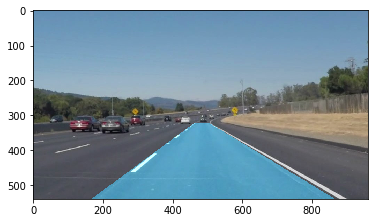

Image solidWhiteRight.jpg displayed below is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


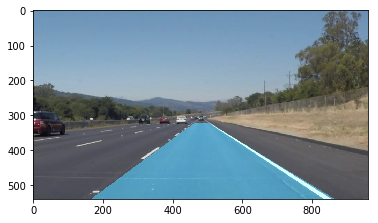

Image solidYellowCurve.jpg displayed below is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


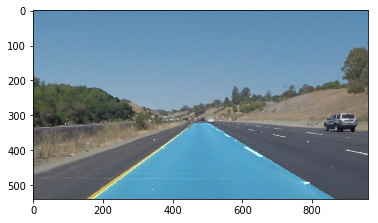

Image solidYellowCurve2.jpg displayed below is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


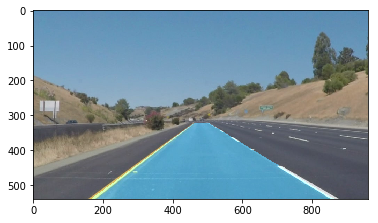

Image solidYellowLeft.jpg displayed below is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


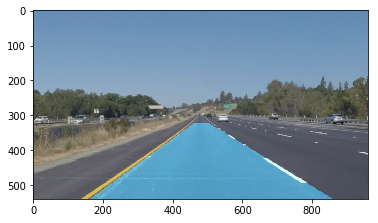

Image whiteCarLaneSwitch.jpg displayed below is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


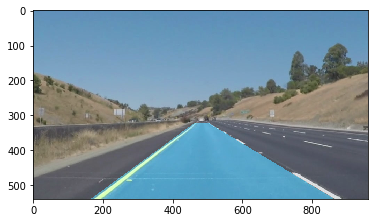

In [21]:
# Printing out test images with lane fill
for image_file in os.listdir("test_images/"):
    img = mpimg.imread("test_images/" + image_file)
    print('Image ' + image_file +' displayed below is:', type(img), 'with dimensions:', img.shape)
    processed_img = process_image(img)
    # mpimg.imsave('test_images_output/Processed_'+ image_file, processed_img) # Did this the first time
    plt.imshow(processed_img)
    plt.show()
    

In [155]:
# Drawing on white lanelines in video

white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████▊| 221/222 [00:18<00:00, 11.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 21 s


In [159]:
# Drawing on yellow lanelines in video

yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)


[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████▉| 681/682 [01:02<00:00, 10.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 1min 4s
